# Task 0 - Load dataset 

In [1]:
import numpy as np
# Use numpy array as a read-only table matrix
# Use lists to do processing (find, sort..)
location = 'attributes.csv'
tmp = np.genfromtxt(location, delimiter=',', dtype=np.string_) #load csv
attributes = tmp[1:,:] #remove headers
attributes_headers = tmp[0]
attributesIds = attributes[:,0].tolist() 
attributesNames = attributes[:,1].tolist() 
print(attributes.shape)
print(attributes_headers)
print(attributes[545])

(13455, 3)
['ProductId' 'AttributeName' 'AttributeValueName']
['11314649' 'Sleeve Length' 'Shortsleeved']


In [2]:
location = 'products.csv'
tmp = np.genfromtxt(location, delimiter=',', dtype=np.string_, comments=None, usecols=np.arange(0,12)) #added 2 conditions for import to work 
products = tmp[1:,:] 
products_headers = tmp[0]
productsIds = products[:,0].tolist()
print(products.shape)
print(products_headers)
print(products[545])

(12631, 12)
['ProductId' 'Description' 'DescriptionDate' 'SeasonOriginal'
 'ProductName' 'Brand' 'Gender' 'Colour' 'Family' 'Category'
 'ArticlePhotoId' 'CreateDate']
['11326917'
 'White and blue striped 3/4 sleeve top from Pleats Please By Issey Miyake. '
 '2016-02-16 22:38:11.413' 'SS16' 'striped 3/4 sleeve top'
 'PLEATS PLEASE BY ISSEY MIYAKE' 'WOMEN' 'BLUE' 'Clothing' 'Tops'
 '6300788' '2016-01-28 14:00:31.883']


In [3]:
import os
imageFullNames = os.listdir('images')
imageIds = [a.split("_", 1)[0] for a in imageFullNames] #remove file name after ProductId
print(imageFullNames[56])
print(imageIds[56])
print(len(imageFullNames))
print(len(imageIds))

11509675_7188420_255.jpg
11509675
12436
12436


# Task 1 - Get comfortable with manipulating the data

In [4]:
from collections import Counter
print(any(count > 3 for count in Counter(attributesIds).itervalues()) ) 
print(any(count > 4 for count in Counter(attributesIds).itervalues()) ) 
print(any(count > 1 for count in Counter(productsIds).itervalues()) ) 
print(any(count > 1 for count in Counter(imageIds).itervalues()) )

True
False
False
False


['11316405' 'Sleeve Length' 'Shortsleeved']
['11316405' 'Black snakeskin print T-shirt  from Michael Michael Kors. '
 '2016-02-15 16:34:23.527' 'SS16' 'snakeskin print T-shirt'
 'MICHAEL MICHAEL KORS' 'WOMEN' 'BLACK' 'Clothing' 'Tops' '6894277'
 '2016-01-21 15:47:47.080']


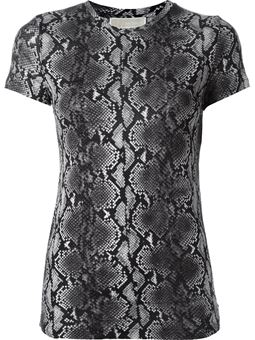

In [5]:
from IPython.display import Image
# Functions to manipulate the data - Better to pre-store everything with a dictionary - Complexity/Computation tradeoff (to do later)
# Get image file name from a ProductId ->  'images/' + imageFullNames[ imageIds.index( myProductId ) ] 
# Get attributes from a ProductId -> attributes[ attributesIds.index( myProductId ) ] 
# Get description from a ProductId - > products[ productsIds.index( myProductId ) ] 
myProductId = attributesIds[587]
print( attributes[ attributesIds.index( myProductId ) ] )
print( products[ productsIds.index( myProductId ) ] )
Image( 'images/' + imageFullNames[ imageIds.index( myProductId ) ] )

# Task 2 - Generate attributes for products missing some (supervised learning)

# A - Build the train, test, application datasets

In [6]:
attributesNamesUnique, counts = np.unique(attributesNames, return_counts=True) #change to 2 to get all sub-attributes
dict(zip(attributesNamesUnique, counts))

{'Body Length': 386,
 'Bracelet': 50,
 'Case': 49,
 'Coat Length': 11,
 'Coat Silhouette': 263,
 'Denim Fit': 10,
 'Detail': 1007,
 'Dress Length': 933,
 'Dress Silhouette': 929,
 'Face Shape': 50,
 'Frame': 242,
 'Heel Height': 1014,
 'Kids Shoe Style': 27,
 'Kids Sleeve Length': 290,
 'Knit Neckline': 486,
 'Leg Length': 591,
 'Lenses': 244,
 'Movement': 50,
 'Neckline': 1300,
 'Occasion': 1647,
 'Rise': 125,
 'Shirt Style': 313,
 'Skirt Length': 382,
 'Sleeve Length': 3056}

In [7]:
#Find products with an image + attribute -> build dataset from them
attributesIdsUnique = list(set(attributesIds)) # (7362) List of ProductIds with at least one attribute and no ProductIds repetition
#attributesIdsUniqueWithImage = [x for x in attributesIdsUnique if x in imageIds] # (7251) #check available image (not for 111) 
attributesIdsWithImage = [x for x in attributesIds if x in imageIds] # (13271)

In [8]:
#Find products with an image + no attribute + add their filename -> apply the algorithm on those products
productsIdsNoAttribute = [x for x in productsIds if x not in attributesIdsUnique] #(5269)
productsIdsNoAttributeWithImage = [x for x in productsIdsNoAttribute if x in imageIds] #(5185)
productsIdsNoAttributeWithImageAddress = [ imageFullNames[ imageIds.index( x ) ] for x in productsIdsNoAttributeWithImage]

In [9]:
# Need to build the dataset -> For each of the 24 attributes, list all ProductIds associated & possessing an image

from collections import defaultdict

dico = defaultdict(list) # dico: key is an attribute, value is a list of ProductId with this attribute & an image
dicoAddress = defaultdict(list) #same but with image file names instead of just ProductId

for (index, myProductId) in enumerate(attributesIds):
    if myProductId in attributesIdsWithImage: 
        key = attributesNames[index]
        dico[key].append(myProductId)
        filename = imageFullNames[ imageIds.index( myProductId ) ]
        dicoAddress[key].append(filename)
    
#ctr = sum(map(len, dico.values())); print(ctr) #used to count number of items in dico (13271)
#length_dico = {key: len(value) for key, value in dico.items()}; print(length_dict) #create another dictionary containing length of lists of values

dicoSmall = defaultdict(list) # Unbalanced training issue and high training time so take only first 10 images of each 24 classes.
for key in dicoAddress:
    tmp = dicoAddress[key]
    dicoSmall[key] = tmp[:10]

In [10]:
dicoSmallTrain = defaultdict(list) # split train:test 7:3
dicoSmallTest = defaultdict(list)
for key in  dicoSmall:
    tmp =  dicoSmall[key]
    dicoSmallTrain[key] = (tmp[:7])
    dicoSmallTest[key] = (tmp[7:10])
#print(dicoSmall['Denim Fit']);print(dicoSmallTrain['Denim Fit']);print(dicoSmallTest['Denim Fit'])

In [11]:
indices = [index for (index, x) in enumerate(attributesNames) if x == 'Sleeve Length'] # (3056) Get indices of products with Sleeve length attibute
tmp = [attributesIds[x] for x in indices] #Get ProductId of those indices
indices = [ indices[index] for (index,x) in enumerate(tmp) if x in imageIds ] # (3009) Remove indices (products) with no image available
a = attributes[indices,0] #ProductIds
b = attributes[indices,2] #sub-attributes
c =  np.asarray( [ imageFullNames[ imageIds.index( myProductId ) ] for myProductId in a] ) #image filenames

classesList = np.unique(b) # (7) number of sub-attributes 
print(classesList)

d = np.zeros(b.shape, dtype=int); counter=0
for x in classesList:
    for y in np.argwhere(b == x):
        counter = ( (counter + 1) % 3 ) + 1 #1 is train, 2 3 is validation
        d[y] = counter
            
dataset = np.column_stack((a, b, c, d)) #Create a numpy array with ProductId | sub-attribute (label) | image filename | train:test split

['3_4 Sleeves' 'Halterneck' 'Longsleeved' 'Shortsleeved' 'Sleeveless'
 'Spaghetti Strap' 'Strapless']


In [12]:
import os

for subattribute in classesList:
    directory = 'data/train/' + subattribute
    if not os.path.exists(directory):
        os.makedirs(directory)
    directory = 'data/validation/' + subattribute
    if not os.path.exists(directory):
        os.makedirs(directory)

#problem with 3/4 sleeves, tell the engineering team -> I changed it to 3_4

from shutil import copyfile
for x in dataset:
    src = 'images/' + x[2]
    if x[3] == '1':
        dst = 'data/train/' + x[1] + '/' + x[2]
        if not os.path.exists(dst): copyfile(src, dst)
    else:
        dst = 'data/validation/' + x[1] + '/' + x[2]
        if not os.path.exists(dst): copyfile(src, dst)

# B - Run the algorithm on the datasets

In [8]:
#Data pre-processing, augmentation, dimensionality reduction
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 16
target_size = (68, 51) #(340, 255) #can reduce dimension here
color_mode = 'grayscale' #'rgb' #can reduce dimension here

(height, width) = target_size
if color_mode == 'grayscale': color_size = 1
if color_mode == 'rgb': color_size = 3

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        zca_whitening=True #like PCA - decorrelating & whitening the data
        )

# this is the augmentation configuration we will use for testing: only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# generate batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=target_size,  # all images will be resized to target_size
        batch_size = batch_size,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=True,
        seed=42)  

# same for validation
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode,
        shuffle=True,
        seed=42)

/home/nathan/miniconda2/lib/python2.7/site-packages/keras_preprocessing/image.py:787: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 1003 images belonging to 7 classes.
Found 2006 images belonging to 7 classes.


In [72]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(height, width, color_size))) #Input layer
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# the model so far outputs 3D feature maps (height, width, features)

In [73]:
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7)) # Output layer
model.add(Activation('softmax')) #'sigmoid' #for multi-label #softmax will give a proba out of all class, sigmoid will give an indepd proba (not mutually exclusive)

model.compile(loss= 'categorical_crossentropy', 
              optimizer= 'Adam', #'rmsprop',
              metrics=['accuracy'])

In [86]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 66, 49, 32)        320       
_________________________________________________________________
activation_26 (Activation)   (None, 66, 49, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 33, 24, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 31, 22, 32)        9248      
_________________________________________________________________
activation_27 (Activation)   (None, 31, 22, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 11, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 9, 64)         18496     
__________

In [85]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 66, 49, 32)        320       
_________________________________________________________________
activation_26 (Activation)   (None, 66, 49, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 33, 24, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 31, 22, 32)        9248      
_________________________________________________________________
activation_27 (Activation)   (None, 31, 22, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 11, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 9, 64)         18496     
__________

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [34]:
# make demo with window + proba written on window (on validation set)
# change the convnet (tune it)
# know how to reload the saved net & try new images through it

In [76]:
epochs= 50

train_samples = np.size(np.where(dataset[:,3]=='1'))
validation_samples = np.size(np.where(dataset[:,3]!='1'))

H = model.fit_generator(
        train_generator,
        steps_per_epoch = train_samples// batch_size,
        epochs = epochs,
        validation_steps= validation_samples // batch_size, 
        validation_data = validation_generator        
        )

Epoch 1/50
62/62 [==============================] - 11s 177ms/step - loss: 1.2035 - acc: 0.5462 - val_loss: 1.1037 - val_acc: 0.5842
Epoch 2/50
62/62 [==============================] - 12s 192ms/step - loss: 1.1998 - acc: 0.5546 - val_loss: 1.0121 - val_acc: 0.6600
Epoch 3/50
62/62 [==============================] - 13s 211ms/step - loss: 1.1523 - acc: 0.5818 - val_loss: 1.0210 - val_acc: 0.6640
Epoch 4/50
62/62 [==============================] - 10s 161ms/step - loss: 1.0911 - acc: 0.5762 - val_loss: 0.9968 - val_acc: 0.6446
Epoch 5/50
62/62 [==============================] - 11s 176ms/step - loss: 1.1541 - acc: 0.5806 - val_loss: 1.0132 - val_acc: 0.6446
Epoch 6/50
62/62 [==============================] - 11s 179ms/step - loss: 1.0940 - acc: 0.5951 - val_loss: 0.9690 - val_acc: 0.6525
Epoch 7/50
62/62 [==============================] - 11s 180ms/step - loss: 1.1376 - acc: 0.6176 - val_loss: 0.9809 - val_acc: 0.6505
Epoch 8/50
62/62 [==============================] - 11s 183ms/step - 

In [81]:
model.save('model.h5')

In [9]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])
plt.savefig('plot')

NameError: name 'epochs' is not defined

In [7]:
# Reload the entire model # Can use for pretrained nets
from keras.models import load_model
#del model  
model = load_model('model')

Using TensorFlow backend.


In [12]:
proba = model.predict_generator(validation_generator,verbose=1)
labels = validation_generator.classes
name_labels = validation_generator.class_indices
labels_names = {v: k for k, v in name_labels.iteritems()}
data = validation_generator.filenames

126/126 [==============================] - 6s 47ms/step


In [13]:
# draw the label on the image
import imutils, cv2

i = 0

Image('data/validation/' + data[i])
real_label = 'real : ' + labels_names[labels[i]]
tmp = np.argmax(proba[i])
guessed_label =  "guessed : {}: {:.2f}%".format( labels_names[ tmp ] , proba[i][tmp] * 100)
print(guessed_label)
print(real_label)


guessed : Sleeveless: 59.73%
real : 3_4 Sleeves


In [ ]:
print(guessed_label)
print(real_label)
